# Generative Models

In [1]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# probability
from scipy.stats import norm
from scipy.stats import multivariate_normal

# machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

## Some Bayes Theorem

Given priors:

- $\pi_A = 0.20$
- $\pi_B = 0.50$
- $\pi_C = 0.30$

And likelihoods:

- $X \mid Y = A \sim N(\mu = 2, \sigma = 1)$
- $X \mid Y = B \sim N(\mu = 3, \sigma = 2)$
- $X \mid Y = C \sim N(\mu = 4, \sigma = 1)$

Calculate posteriors:

- $P(Y = A \mid X = 3.4)$
- $P(Y = B \mid X = 3.4)$
- $P(Y = C \mid X = 3.4)$

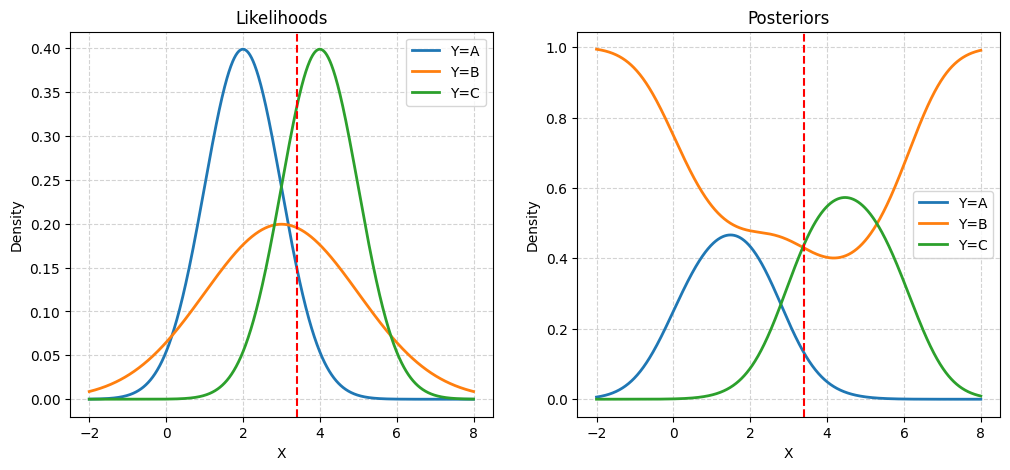

In [2]:
x = np.linspace(-2, 8, 1000)
mu = [2, 3, 4]
sigma = [1, 2, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i in range(3):
    y = norm.pdf(x, loc=mu[i], scale=sigma[i])
    axs[0].plot(x, y, label=f"Y={chr(65+i)}", linewidth=2)

axs[0].axvline(x=3.4, color="red", linestyle="--")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Density")
axs[0].grid(color="lightgrey", linestyle="--")
axs[0].set_title("Likelihoods")
axs[0].legend()

priors = [0.20, 0.50, 0.30]

z = []
for i in range(len(x)):
    z.append(np.sum(priors * norm.pdf(x[i], loc=mu, scale=sigma)))

for i in range(3):
    y = priors[i] * norm.pdf(x, loc=mu[i], scale=sigma[i])
    axs[1].plot(x, y / z, label=f"Y={chr(65+i)}", linewidth=2)

axs[1].axvline(x=3.4, color="red", linestyle="--")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Density")
axs[1].grid(color="lightgrey", linestyle="--")
axs[1].set_title("Posteriors")
axs[1].legend()

plt.show()

In [3]:
priors = [0.20, 0.50, 0.30]
likelihoods = norm.pdf(x=3.4, loc=[2, 3, 4], scale=[1, 2, 1])
priors * likelihoods / (np.sum(priors * likelihoods))

array([0.13152821, 0.42938969, 0.43908211])

- $P(Y = A \mid X = 3.7) = 0.13152821$
- $P(Y = B \mid X = 3.7) = 0.42938969$
- $P(Y = C \mid X = 3.7) = 0.43908211$

## Generative Models

$$
p_k(\boldsymbol{x}) = 
P(Y = k \mid \boldsymbol{X} = \boldsymbol{x}) = 
\frac{\pi_k \cdot f_k(\boldsymbol{x})}{\sum_{g = 1}^{G} \pi_g \cdot f_g(\boldsymbol{x})}
$$

### Helper Functions

In [4]:
def make_plot(mu1, cov1, mu2, cov2, seed=42):

    # control random sampling
    np.random.seed(seed)

    # create two multivariate normal distributions
    dist1 = multivariate_normal(mu1, cov1)
    dist2 = multivariate_normal(mu2, cov2)

    # generate random samples from each distribution
    samples1 = dist1.rvs(size=100)
    samples2 = dist2.rvs(size=100)

    # change color maps for scatter plot
    cmap1 = plt.get_cmap("Blues")
    cmap2 = plt.get_cmap("Oranges")

    # arrange plot grid points
    x_min = np.min([np.min(samples1[:, 0]), np.min(samples2[:, 0])]) - 1
    x_max = np.max([np.max(samples1[:, 0]), np.max(samples2[:, 0])]) + 1
    y_min = np.min([np.min(samples1[:, 1]), np.min(samples2[:, 1])]) - 1
    y_max = np.max([np.max(samples1[:, 1]), np.max(samples2[:, 1])]) + 1
    x, y = np.mgrid[x_min:x_max:0.01, y_min:y_max:0.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    # setup plots
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # plot true distributions
    ax[0].contourf(x, y, dist1.pdf(pos), cmap="Blues")
    ax[0].contour(x, y, dist1.pdf(pos), colors="k")
    ax[0].contourf(x, y, dist2.pdf(pos), cmap="Oranges", alpha=0.5)
    ax[0].contour(x, y, dist2.pdf(pos), colors="k")
    ax[0].grid(color="lightgrey", linestyle="--")
    ax[0].set_title("True Distribution")
    ax[0].set_xlabel(r"$x_1$")
    ax[0].set_ylabel(r"$x_2$")

    # plot sampled data
    ax[1].scatter(samples1[:, 0], samples1[:, 1], color=cmap1(0.5))
    ax[1].scatter(samples2[:, 0], samples2[:, 1], color=cmap2(0.5))
    ax[1].set_title("Sampled Data")
    ax[1].grid(color="lightgrey", linestyle="--")
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(y_min, y_max)
    ax[1].set_xlim(x_min, x_max)
    ax[1].set_ylim(y_min, y_max)
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")

    # shot plot
    plt.show()

In [5]:
# create mean (mu) and covariance (cov) arrays
def create_params(mu_1, mu_2, sigma_1, sigma_2, corr):
    # Create mean vector
    mu = np.array([mu_1, mu_2])
    # Calculate covariance matrix
    cov = np.array([[sigma_1**2, corr * sigma_1 * sigma_2], [corr * sigma_1 * sigma_2, sigma_2**2]])
    # Return both
    return mu, cov

In [6]:
# print parameter information
def print_setup_parameter_info(mu1, cov1, mu2, cov2):
    print("Mean X when Y = Blue:", mu1)
    print("Covariance of X when Y = Blue:", "\n", cov1)
    print("Mean X when Y = Orange:", mu2)
    print("Covariance of X when Y = Orange:", "\n", cov2)

### Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis, **LDA**, assumes that the features are multivariate normal conditioned on the target classes. Importantly, LDA assumes the same covariance (shape) within each class.

$$
\boldsymbol{X} \mid Y = k \sim N(\boldsymbol{\mu}_k, \boldsymbol\Sigma)
$$

$$
\boldsymbol\Sigma = \boldsymbol\Sigma_1 = \boldsymbol\Sigma_2 = \cdots = \boldsymbol\Sigma_G
$$

In [7]:
# make a two-class LDA setup
mu1, cov1 = create_params(0, 0, 1, 1, 0.5)
mu2, cov2 = create_params(2, 2, 1, 1, 0.5)
print_setup_parameter_info(mu1, cov1, mu2, cov2)

Mean X when Y = Blue: [0 0]
Covariance of X when Y = Blue: 
 [[1.  0.5]
 [0.5 1. ]]
Mean X when Y = Orange: [2 2]
Covariance of X when Y = Orange: 
 [[1.  0.5]
 [0.5 1. ]]


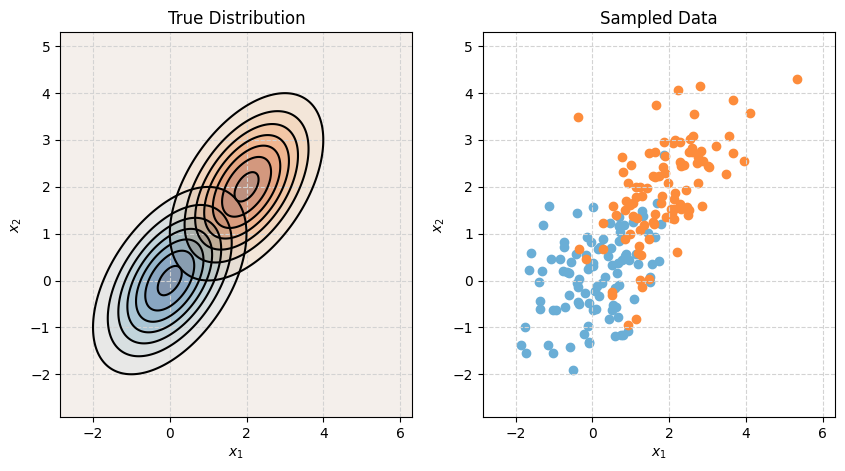

In [8]:
# plot (true) conditional distributions of X and sampled data
make_plot(mu1, cov1, mu2, cov2)

### Quadratic Discriminant Analysis (QDA)

Quadratic Discriminant Analysis, **QDA**, also assumes that the features are multivariate normal conditioned on the target classes. However, unlike LDA, QDA makes fewer assumptions on the covariances (shapes). QDA allows the covariance to be completely different within each class.

$$
\boldsymbol X \mid Y = k \sim N(\boldsymbol\mu_k, \boldsymbol\Sigma_k)
$$

In [9]:
# make a two-class QDA setup
mu1, cov1 = create_params(0, 0, 2, 1, 0.5)
mu2, cov2 = create_params(2, 2, 1, 0.5, -0.5)
print_setup_parameter_info(mu1, cov1, mu2, cov2)

Mean X when Y = Blue: [0 0]
Covariance of X when Y = Blue: 
 [[4. 1.]
 [1. 1.]]
Mean X when Y = Orange: [2 2]
Covariance of X when Y = Orange: 
 [[ 1.   -0.25]
 [-0.25  0.25]]


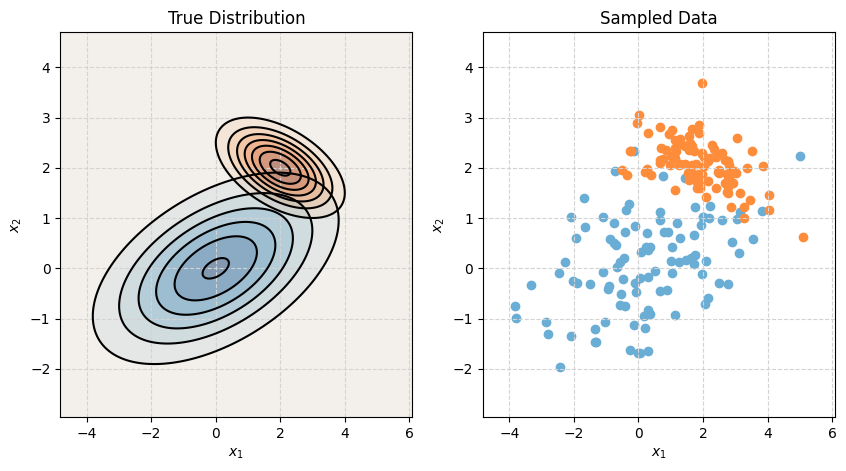

In [10]:
# plot (true) conditional distributions of X and sampled data
make_plot(mu1, cov1, mu2, cov2)

### Naive Bayes (NB)

Naive Bayes comes in many forms. With only numeric features, it often assumes a multivariate normal conditioned on the target classes, but a very specific multivariate normal.

$$
{\boldsymbol X} \mid Y = k \sim N(\boldsymbol\mu_k, \boldsymbol\Sigma_k)
$$

Naive Bayes assumes that the features $X_1, X_2, \ldots, X_p$ are independent given $Y = k$. This is the "naive" part of naive Bayes. The Bayes part is nothing new. Since $X_1, X_2, \ldots, X_p$ are assumed independent, each $\boldsymbol\Sigma_k$ is diagonal, that is, we assume no correlation between features. Independence implies zero correlation.

$$
\boldsymbol\Sigma_k = 
\begin{bmatrix}
\sigma_{1}^2 & 0 & \cdots & 0 \\
0 & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & 0 \\
0 & \cdots & 0 & \sigma_{p}^2 \\
\end{bmatrix}
$$

This will allow us to write the (joint) likelihood as a product of univariate distributions. In this case, the product of univariate normal distributions instead of a (joint) multivariate distribution.

$$
f_k(\boldsymbol x) = \prod_{j = 1}^{p} f_{kj}(\boldsymbol x_j)
$$

Here, $f_{kj}(\boldsymbol x_j)$ is the density for the $j$-th feature conditioned on the $k$-th class. Notice that there is a $\sigma_{kj}$ for each feature for each class.

$$
f_{kj}(\boldsymbol x_j) = \frac{1}{\sigma_{kj}\sqrt{2\pi}}\exp\left[-\frac{1}{2}\left(\frac{x_j - \mu_{kj}}{\sigma_{kj}}\right)^2\right]
$$

When $p = 1$, this version of naive Bayes is equivalent to QDA.


In [11]:
# make a two-class NB setup
mu1, cov1 = create_params(0, 0, 2, 1, 0)
mu2, cov2 = create_params(2, 2, 1, 0.5, 0)
print_setup_parameter_info(mu1, cov1, mu2, cov2)

Mean X when Y = Blue: [0 0]
Covariance of X when Y = Blue: 
 [[4 0]
 [0 1]]
Mean X when Y = Orange: [2 2]
Covariance of X when Y = Orange: 
 [[1.   0.  ]
 [0.   0.25]]


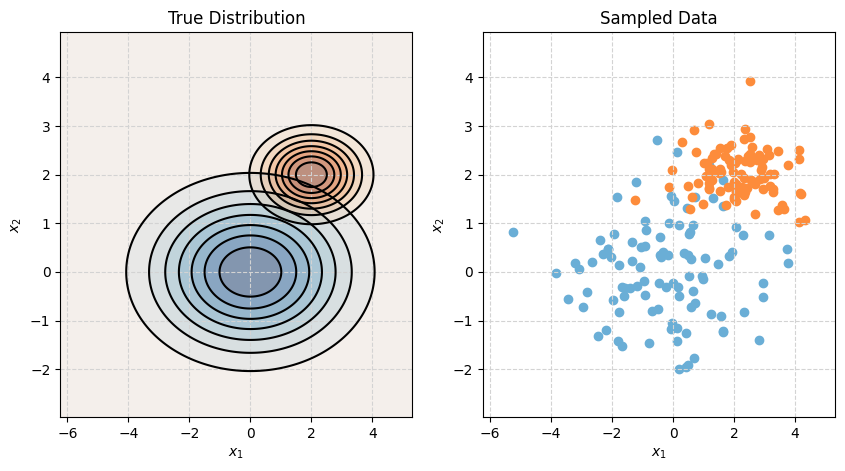

In [12]:
# plot (true) conditional distributions of X and sampled data
make_plot(mu1, cov1, mu2, cov2)

## Generative Models with `sklearn`

In [13]:
# function to generate data according to LDA, QDA, or NB
def generate_data(n1, n2, n3, mu1, mu2, mu3, cov1, cov2, cov3, seed=307):

    # control random sampling
    np.random.seed(seed)

    # generate data for class A
    data1 = np.random.multivariate_normal(mu1, cov1, n1)
    labels1 = np.repeat("A", n1)

    # generate data for class B
    data2 = np.random.multivariate_normal(mu2, cov2, n2)
    labels2 = np.repeat("B", n2)

    # generate data for class C
    data3 = np.random.multivariate_normal(mu3, cov3, n3)
    labels3 = np.repeat("C", n3)

    # combine data and labels
    data = np.concatenate((data1, data2, data3))
    labels = np.concatenate((labels1, labels2, labels3))

    # make X and y
    X = pd.DataFrame(data, columns=["x1", "x2"])
    y = pd.Series(labels)

    return X, y

In [14]:
# setup sample sizes
n1 = 500
n2 = 500
n3 = 500

# setup parameters
mu1, cov1 = create_params(0, 0, 2, 1, 0.5)
mu2, cov2 = create_params(2, 2, 1, 2, -0.5)
mu3, cov3 = create_params(0, 2, 1, 1, 0.5)

In [15]:
# generate train and test data
X_train, y_train = generate_data(n1, n2, n3, mu1, mu2, mu3, cov1, cov2, cov3)
X_test, y_test = generate_data(n1, n2, n3, mu1, mu2, mu3, cov1, cov2, cov3)

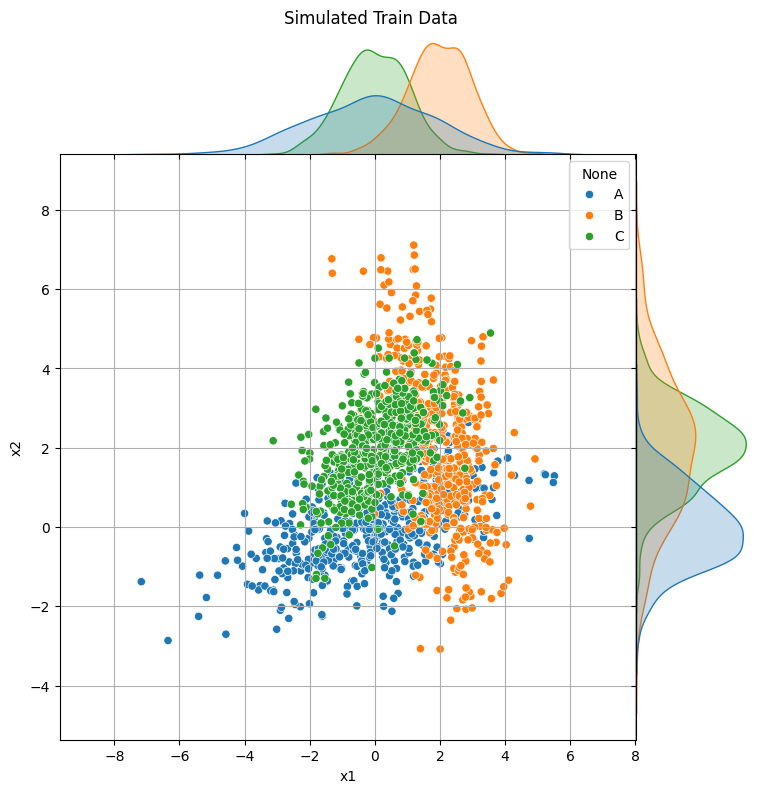

In [16]:
# plot the train data
p = sns.jointplot(x="x1", y="x2", data=X_train, hue=y_train, space=0)
p.figure.suptitle("Simulated Train Data", y=1.01)
p.ax_joint.grid(True)
p.figure.set_size_inches(8, 8)

In [17]:
# (gaussian) naive bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Gaussian NB, Test Accuracy:", accuracy)

# linear discriminant analysis
lda = LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("LDA, Test Accuracy:", accuracy)

# quadratic discriminant analysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("QDA, Test Accuracy:", accuracy)

Gaussian NB, Test Accuracy: 0.7573333333333333
LDA, Test Accuracy: 0.7166666666666667
QDA, Test Accuracy: 0.778


In [18]:
print("Classes:", gnb.classes_)
print("Feature names:", gnb.feature_names_in_)
print("NB, Estimated Class Priors:", gnb.class_prior_)
print("NB, Estimated Mean of each feature per class:", "\n", gnb.theta_)
print("NB, Estimated Variance of each feature per class:", "\n", gnb.var_)

Classes: ['A' 'B' 'C']
Feature names: ['x1' 'x2']
NB, Estimated Class Priors: [0.33333333 0.33333333 0.33333333]
NB, Estimated Mean of each feature per class: 
 [[-0.10778418 -0.02552625]
 [ 1.96383823  2.02196766]
 [-0.0044841   1.98771465]]
NB, Estimated Variance of each feature per class: 
 [[3.86238562 0.95924211]
 [0.91382434 3.47167746]
 [1.0167942  1.02494661]]


In [19]:
print("Classes:", lda.classes_)
print("Feature names:", lda.feature_names_in_)
print("LDA, Estimated Class Priors:", lda.priors_)
print("LDA, Estimated Mean of each feature per class:", "\n", lda.means_)
print("LDA, Estimated Covariance Matrix:")
lda.covariance_

Classes: ['A' 'B' 'C']
Feature names: ['x1' 'x2']
LDA, Estimated Class Priors: [0.33333333 0.33333333 0.33333333]
LDA, Estimated Mean of each feature per class: 
 [[-0.10778418 -0.02552625]
 [ 1.96383823  2.02196766]
 [-0.0044841   1.98771465]]
LDA, Estimated Covariance Matrix:


array([[1.93100139, 0.22670227],
       [0.22670227, 1.81862206]])

In [20]:
print("Classes:", qda.classes_)
print("Feature names:", qda.feature_names_in_)
print("QDA, Estimated Class Priors:", qda.priors_)
print("QDA, Estimated Mean of each feature per class:", "\n", qda.means_)
print("QDA, Estimated Covariance Matrix of each feature per class:")
qda.covariance_

Classes: ['A' 'B' 'C']
Feature names: ['x1' 'x2']
QDA, Estimated Class Priors: [0.33333333 0.33333333 0.33333333]
QDA, Estimated Mean of each feature per class: 
 [[-0.10778418 -0.02552625]
 [ 1.96383823  2.02196766]
 [-0.0044841   1.98771465]]
QDA, Estimated Covariance Matrix of each feature per class:


[array([[3.87012587, 1.05019139],
        [1.05019139, 0.96116443]]),
 array([[ 0.91565565, -0.8719703 ],
        [-0.8719703 ,  3.47863472]]),
 array([[1.01883186, 0.50324866],
        [0.50324866, 1.02700061]])]

### Priors

In [21]:
# setup sample sizes
n1_train = 500
n2_train = 300
n3_train = 700
n1_test = 500
n2_test = 500
n3_test = 500

# setup parameters
mu1, cov1 = create_params(0, 0, 2, 1, 0.5)
mu2, cov2 = create_params(2, 2, 1, 2, -0.5)
mu3, cov3 = create_params(0, 2, 1, 1, 0.5)

# generate train and test data
X_train, y_train = generate_data(n1_train, n2_train, n3_train, mu1, mu2, mu3, cov1, cov2, cov3)
X_test, y_test = generate_data(n1_test, n2_test, n3_test, mu1, mu2, mu3, cov1, cov2, cov3)

In [22]:
# quadratic discriminant analysis, estimated prior
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("QDA, Test Accuracy:", accuracy)
print(qda.priors_)

QDA, Test Accuracy: 0.7626666666666667
[0.33333333 0.2        0.46666667]


In [23]:
# quadratic discriminant analysis, specified prior
qda = QuadraticDiscriminantAnalysis(store_covariance=True, priors=[0.33, 0.33, 0.33])
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("QDA, Test Accuracy:", accuracy)
print(qda.priors_)

QDA, Test Accuracy: 0.7773333333333333
[0.33 0.33 0.33]
